In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import json
import os
import shutil
import random
from PIL import Image

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.3.1
No GPU found, using CPU instead.


In [5]:
# Définir les transformations pour les données
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionner les images à 224x224
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliser les images (FashionMNIST est en niveaux de gris)
])

# Télécharger et charger le jeu de données FashionMNIST
dataset = datasets.FashionMNIST(root='./data', 
                                train=True, 
                                transform=transform, 
                                download=True)

# Séparer les données en ensemble d'entraînement et de test
# Calculer la taille de chaque sous-dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Diviser le dataset en ensemble d'entraînement et de test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Créer des DataLoader pour les ensembles d'entraînement et de test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Afficher les tailles des datasets pour vérification
print(f'Taille du dataset d\'entraînement: {len(train_dataset)}')
print(f'Taille du dataset de test: {len(test_dataset)}')

# Vérification des données
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

Taille du dataset d'entraînement: 48000
Taille du dataset de test: 12000
data: torch.Size([64, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([64]) type: torch.LongTensor


Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=12, bias=True)
    (6): ReLU()
    (7): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
Training epoch: 1
Average loss: 0.654456
Training epoch: 2
Average loss: 0.616650
Training epoch: 3
Average loss: 0.612870
Training epoch: 4
Average loss: 0.611340
Training epoch: 5
Average loss: 0.610264
Training epoch: 6
Average loss: 0.609419
Training epoch: 7
Average loss: 0.608716

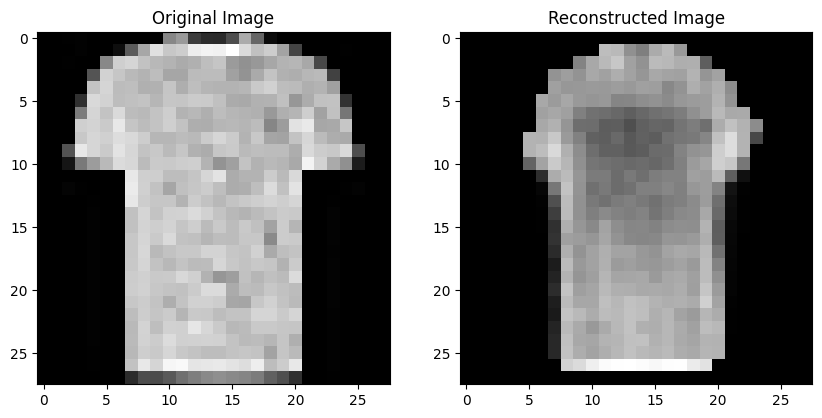

In [6]:
# Définition de l'autoencodeur
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fonction de formation
def train(data_loader, model, criterion, optimizer):
    model.train()
    num_batches = len(data_loader)
    total_loss = 0

    for data, _ in data_loader:
        data = data.to(device)

        # Effectuer une passe avant
        output = model(data)

        # Calculer la perte
        loss = criterion(output, data.view(-1, 28 * 28))
        total_loss += loss.item()

        # Rétropropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / num_batches
    print(f"Average loss: {train_loss:.6f}")

# Entraînement de l'autoencodeur
epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch + 1}")
    train(train_loader, model, criterion, optimizer)

# Visualisation des résultats
def visualize(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            output = output.view(-1, 1, 28, 28).cpu().numpy()
            break

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[0].cpu().numpy().squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(output[0].squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    plt.show()

# Visualiser les résultats sur le jeu de test
visualize(model, test_loader)